In [28]:
import math
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import splev, splrep

from openalea.mtg import MTG
from openalea.archicrop.archicrop import ArchiCrop
from openalea.archicrop.stics_io import stics_output
from ipywidgets import interact, IntSlider, fixed, FloatSlider

In [35]:
def generate_tillers(nb_phy, phyllochron, duration, nb_tillers, tiller_delay):
    '''
    Generates a MTG of a plant with main stem and tillers, considering the delay of appearance of tillers and the timing of appearance and elongation of the phytomers.
    Return a dict with the order and the delay of each tiller.
    '''
    ranks = range(1, nb_phy + 1)
    ntop = max(ranks) - np.array(ranks) + 1
    
    tt = 0
    dtt = phyllochron * duration
    
    tiller_points = []
    rank_tillers = []
    
    g = MTG()
    # Add a root vertex for the plant
    vid_plant = g.add_component(g.root, label="Plant", edge_type="/") 
    # Add a plant vertex for the main axis
    vid_axis = g.add_component(vid_plant, label="MainAxis", edge_type="/")
 
    # iterate over the number of phytomers of the main stem
    first = True
    for rank in ranks:
        if first:
            vid = g.add_component(vid_axis)
            first = False
        else:
            vid = g.add_child(vid, edge_type="<")
        g.node(vid).start_tt = tt 
        g.node(vid).end_tt = tt + dtt
        tt += phyllochron
        tiller_points.append((vid, tt + tiller_delay*phyllochron))
    
    for i in range(nb_tillers):
        # add a tiller
        vid, time = tiller_points.pop(0)
    
        tillers = []
        axis_id = g.complex(vid)
        r = g.Rank(vid) + 1  # Number of edges from the root of the axis
        rank_tillers.append(r)
        n = len(g.Axis(vid))
        len_tiller = n - r - 1  # we remove the parent that does not belong to the tiller 
        nb_phy = len_tiller
    
        ranks = range(1, nb_phy + 1)
        ntop = max(ranks) - np.array(ranks) + 1
    
        tt = time
    
        tid = g.add_child(parent=axis_id, edge_type='+', label='Axis')
    
        first = True
        for rank in ranks:
            if first:
                vid, tid2 = g.add_child_and_complex(parent=vid, complex=tid, edge_type='+')
                first = False
            else:
                vid = g.add_child(parent=vid, edge_type='<')
            g.node(vid).start_tt = tt
            g.node(vid).end_tt = tt + dtt
            tt += phyllochron
            tillers.append((vid, tt + tiller_delay*phyllochron))
    
        tiller_points.extend(tillers)
        tiller_points.sort(key=lambda x: x[1]) # sorted by time
        tiller_points = tiller_points[:nb_tillers-i]

    axes = g.vertices(scale=2)  # scale=2: axes
    T = {i+1: (g.order(axis), g.order(axis)+r) for i,(axis,r) in enumerate(zip(axes[1:],rank_tillers))} # {id: (order, delay)}

    return T 

In [112]:
def resolve_organ_growth(N, nb_tillers, duration, la_ends, tillers):
    '''
    A: matrix of the advancement of elongation of phytomers i at the end of elongation of phytomers j on the main stem
    T: list of matrices of the advancement of elongation of phytomers i at the end of elongation of phytomers j on tillers
    B: vector of constrained plant-scale dynamics evaluated at end of elongation of phytomers of the main stem
    Resolve (A+∑T)S=B
    '''
    
    A = np.zeros((N, N)) 
    B = np.zeros(N)
    if nb_tillers > 0:
        T = {i: np.zeros((N, N)) for i in range(1,nb_tillers+1)}

    for x in range(0, N):
        A[x, min(x+1,N-1)] = (duration - 1) / duration
        for i in range(x+1):
            A[x, i] = 1
        B[x] = la_ends[x] 
        if nb_tillers > 0:
            for id,t in T.items():
                delay = tillers[id][1]
                if x >= delay:
                    t[x, min(x+1-delay,N-1)] = (duration - 1) / duration
                    for j in range(x+1):
                        t[x, max(0,j-delay)] = 1

    # Sum matrices of main stem and tillers 
    P = A
    if nb_tillers > 0:
        for id,t in T.items():
            # print(t)
            P += reduction_factor**tillers[id][0]*t

    # print(P)
    S = np.linalg.solve(P, B)

    return S

In [106]:
def compute_LA_at_end_of_dev_of_leaves(nb_phy, phyllochron, duration, thermal_time, leaf_area_plant):
    '''
    Evaluate constrained plant-scale dynamics at end of elongation of phytomers of the main stem.
    '''
    starts = []
    ends = []
    for i in range(nb_phy):
        start = i * phyllochron + thermal_time[0]
        end = start + phyllochron * duration
        starts.append(round(start))
        ends.append(round(end))
    spl = splrep(thermal_time, leaf_area_plant)
    la_ends = splev(ends, spl)
    return la_ends

In [34]:
tec_file='D:/ArchiCrop/data/02NT18SorgV2D1_tec.xml'
plant_file='D:/ArchiCrop/data/sorgho_imp_M_v10_plt.xml'
stics_output_file='D:/ArchiCrop/data/mod_s02NT18SorgV2D1.sti'
stics_output_file_pot='D:/ArchiCrop/data/mod_s02NT18SorgV2D1_no_stress.sti'

density, daily_dynamics, lifespan, lifespan_early, thermal_time, leaf_area_plant, sen_leaf_area_plant, height_canopy, end_juv, end_veg, index_end_veg = stics_output(tec_file, plant_file, stics_output_file)
density_pot, daily_dynamics_pot, lifespan_pot, lifespan_early_pot, thermal_time_pot, leaf_area_plant_pot, sen_leaf_area_plant_pot, height_canopy_pot, end_juv_pot, end_veg_pot, index_end_veg_pot = stics_output(tec_file, plant_file, stics_output_file_pot)

thermal_time = thermal_time[:index_end_veg+1]
leaf_area_plant = leaf_area_plant[:index_end_veg+1]
leaf_area_plant_pot = leaf_area_plant_pot[:index_end_veg+1]

In [108]:
nb_phy = 10
duration = 1.6
nb_tillers = 2
tiller_delay = 2
reduction_factor = 0.8

In [109]:
phyllochron = (end_veg-thermal_time[0])/(nb_phy + duration)

In [102]:
tillers = generate_tillers(nb_phy, phyllochron, duration, nb_tillers, tiller_delay)
tillers

{1: (1, 2), 2: (1, 3)}

In [107]:
la_ends = compute_LA_at_end_of_dev_of_leaves(nb_phy, phyllochron, duration, thermal_time, leaf_area_plant)
S = resolve_organ_growth(nb_phy, nb_tillers, duration, la_ends, tillers)
S

[[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [1.    0.375 0.    0.    0.    0.    0.    0.    0.    0.   ]
 [1.    1.    0.375 0.    0.    0.    0.    0.    0.    0.   ]
 [1.    1.    1.    0.375 0.    0.    0.    0.    0.    0.   ]
 [1.    1.    1.    1.    0.375 0.    0.    0.    0.    0.   ]
 [1.    1.    1.    1.    1.    0.375 0.    0.    0.    0.   ]
 [1.    1.    1.    1.    1.    1.    0.375 0.    0.    0.   ]
 [1.    1.    1.    1.    1.    1.    1.    0.375 0.    0.   ]
 [1.    1.    1.    1.    1.    1.    1.    1.    0.375 0.   ]]
[[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [1.    0.375 0.    0.    0.    0.    0.    0.    0.    0.   ]
 [1.    1.    0.375 0.    0.    0.    0.    0.    0.    0.   ]
 [1.    1.    1.    0.375 0.    0.    0.    0.    0.  

array([   2.84173853,   29.54383145,   54.59717902,  169.23782238,
        355.00090158,  477.21193239,  569.95255066,    1.48158454,
       -683.75976712,  165.90974887])

In [104]:
S_single = resolve_organ_growth(nb_phy, 0, duration, la_ends, tillers)

[[1.    0.375 0.    0.    0.    0.    0.    0.    0.    0.   ]
 [1.    1.    0.375 0.    0.    0.    0.    0.    0.    0.   ]
 [1.    1.    1.    0.375 0.    0.    0.    0.    0.    0.   ]
 [1.    1.    1.    1.    0.375 0.    0.    0.    0.    0.   ]
 [1.    1.    1.    1.    1.    0.375 0.    0.    0.    0.   ]
 [1.    1.    1.    1.    1.    1.    0.375 0.    0.    0.   ]
 [1.    1.    1.    1.    1.    1.    1.    0.375 0.    0.   ]
 [1.    1.    1.    1.    1.    1.    1.    1.    0.375 0.   ]
 [1.    1.    1.    1.    1.    1.    1.    1.    1.    0.375]
 [1.    1.    1.    1.    1.    1.    1.    1.    1.    1.   ]]


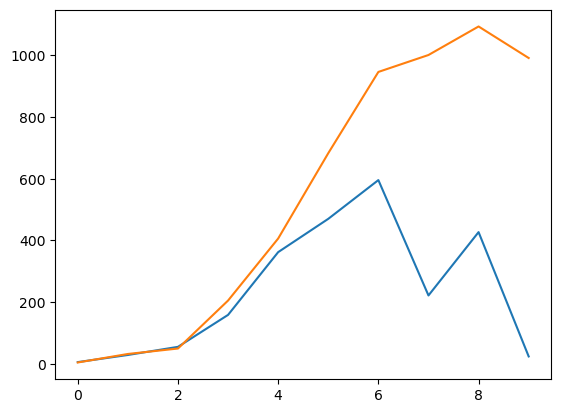

In [105]:
plt.plot(S)
plt.plot(S_single)
plt.show()

In [134]:
def f(nb_phy = 10, duration = 1.6, nb_tillers = 2, tiller_delay = 2, reduction_factor = 0.8, thermal_time=thermal_time, leaf_area_plant=leaf_area_plant):
    phyllochron = (end_veg-thermal_time[0])/(nb_phy + duration)
    tillers = generate_tillers(nb_phy, phyllochron, duration, nb_tillers, tiller_delay)
    print(tillers)
    la_ends = compute_LA_at_end_of_dev_of_leaves(nb_phy, phyllochron, duration, thermal_time, leaf_area_plant)
    S = resolve_organ_growth(nb_phy, nb_tillers, duration, la_ends, tillers)
    S_single = resolve_organ_growth(nb_phy, 0, duration, la_ends, tillers)
    plt.plot(range(1,nb_phy+1), S, label='With tillers')
    plt.plot(range(1,nb_phy+1), S_single, label='Single stem')
    plt.plot(range(1,nb_phy+1), [0]*nb_phy, color='black')
    plt.legend()
    plt.show()

In [135]:
interact(f, 
         nb_phy = IntSlider(min=8,max=30,step=1,value=10), 
         nb_tillers = IntSlider(min=0,max=10,step=1,value=2),
         reduction_factor = FloatSlider(min=0.1,max=1.0,step=0.1,value=0.8),
         thermal_time=fixed(thermal_time),
         leaf_area_plant=fixed(leaf_area_plant),
         duration=fixed(1.6),
         tiller_delay=fixed(2))

interactive(children=(IntSlider(value=10, description='nb_phy', max=30, min=8), IntSlider(value=2, description…

<function __main__.f(nb_phy=10, duration=1.6, nb_tillers=2, tiller_delay=2, reduction_factor=0.8, thermal_time=[66.5962, 77.7857, 88.934, 101.6179, 114.1625, 125.1774, 137.916, 151.1264, 162.7788, 176.0939, 188.936, 203.0103, 216.958, 230.7735, 245.6918, 259.4848, 270.3776, 283.1174, 294.0696, 303.9594, 315.6526, 328.1418, 339.7291, 352.1125, 365.848, 380.1691, 390.9273, 403.0976, 413.7346, 426.4432, 437.4328, 449.3314, 460.6621, 472.5048, 484.2391, 497.3398, 508.2819, 520.5085, 533.4225, 544.5587, 556.7549, 570.2299, 582.9271, 596.0726, 608.7742, 621.2125, 634.2286, 647.8529, 661.7628, 676.4794, 689.4456, 701.352, 714.6163, 727.8541, 740.8247, 754.601, 769.9641, 783.5577, 794.3532, 807.8827, 819.2122, 833.0236, 846.5198, 858.1298, 872.451, 886.0505, 900.7184, 914.8066, 929.3533, 943.3993], leaf_area_plant=[0.037, 0.1111, 0.1852, 0.2778, 0.3889, 1.3704, 2.5741, 4.4444, 6.3333, 8.8889, 11.8148, 15.6481, 20.2222, 25.6296, 32.7593, 40.1481, 47.1852, 56.9815, 66.5741, 76.3148, 89.8519, 106

In [136]:
interact(f, 
         nb_phy = IntSlider(min=8,max=30,step=1,value=10), 
         nb_tillers = IntSlider(min=0,max=10,step=1,value=2),
         reduction_factor = FloatSlider(min=0.1,max=1.0,step=0.1,value=0.8),
         thermal_time=fixed(thermal_time),
         leaf_area_plant=fixed(leaf_area_plant_pot),
         duration=fixed(1.6),
         tiller_delay=fixed(2))

interactive(children=(IntSlider(value=10, description='nb_phy', max=30, min=8), IntSlider(value=2, description…

<function __main__.f(nb_phy=10, duration=1.6, nb_tillers=2, tiller_delay=2, reduction_factor=0.8, thermal_time=[66.5962, 77.7857, 88.934, 101.6179, 114.1625, 125.1774, 137.916, 151.1264, 162.7788, 176.0939, 188.936, 203.0103, 216.958, 230.7735, 245.6918, 259.4848, 270.3776, 283.1174, 294.0696, 303.9594, 315.6526, 328.1418, 339.7291, 352.1125, 365.848, 380.1691, 390.9273, 403.0976, 413.7346, 426.4432, 437.4328, 449.3314, 460.6621, 472.5048, 484.2391, 497.3398, 508.2819, 520.5085, 533.4225, 544.5587, 556.7549, 570.2299, 582.9271, 596.0726, 608.7742, 621.2125, 634.2286, 647.8529, 661.7628, 676.4794, 689.4456, 701.352, 714.6163, 727.8541, 740.8247, 754.601, 769.9641, 783.5577, 794.3532, 807.8827, 819.2122, 833.0236, 846.5198, 858.1298, 872.451, 886.0505, 900.7184, 914.8066, 929.3533, 943.3993], leaf_area_plant=[0.037, 0.1111, 0.1852, 0.2778, 0.3889, 1.3704, 2.5741, 4.4444, 6.3333, 8.8889, 11.8148, 15.6481, 20.2222, 25.6296, 32.7593, 40.1481, 47.1852, 56.9815, 66.5741, 76.3148, 89.8519, 106